# Desafio: Transformando o Problema para Classificação Binária

**Aula:** Modelos Clássicos de Classificação  

**Ministrante:** Miguel Euripedes

---

Objetivo do Desafio
Neste exercício, vamos adaptar nosso problema original de classificação multiclasse para um problema de classificação binária. Em vez de prever três tipos de carga, nosso novo objetivo será mais específico:

Queremos prever se a fábrica está operando em "Carga Máxima" (High Load) ou não.

Esta é uma tarefa muito comum na indústria, onde o foco pode ser em detectar picos de consumo para otimização de custos ou manutenção preditiva.

Para resolver este novo problema, vamos:

1. Engenharia de Features: Criar uma nova variável-alvo binária.

2. Treinar um novo modelo: Utilizaremos a Regressão Logística, um algoritmo clássico e eficaz para classificação binária.

3. Avaliar com Métricas Apropriadas: Além da acurácia, vamos explorar a Curva ROC e a métrica AUC, que são especialmente úteis para problemas de classificação binária.

In [ ]:
# Se o pacote `ucimlrepo` não estiver instalado, esta célula irá instalá-lo.
# Ele nos permite buscar datasets diretamente do repositório da UCI.
!pip install ucimlrepo -q

In [ ]:
# Reutilizamos a maioria das bibliotecas anteriores e adicionamos a Regressão Logística e métricas de ROC.
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from ucimlrepo import fetch_ucirepo
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc


## Carregamento e Preparação dos Dados

Primeiro, vamos carregar os dados como fizemos no exercício anterior.

In [ ]:
# Carregamento do dataset
steel_industry_energy_consumption = fetch_ucirepo(id=851)
X = steel_industry_energy_consumption.data.features
y = steel_industry_energy_consumption.data.targets
df = pd.concat([X, y], axis=1)

## Criando o Alvo Binário

Aqui está a principal mudança. Vamos criar uma nova coluna Target onde:

- `1` representará a classe de interesse (`Maximum_Load`).

- `0` representará todas as outras classes (`Light_Load e Medium_Load`).

Depois, vamos analisar o balanceamento dessa nova variável.

In [ ]:
# Criando a variável-alvo binária
# A função .map() é perfeita para essa transformação.
df['Target'] = df['Load_Type'].map({
    'Maximum_Load': 1,
    'Light_Load': 0,
    'Medium_Load': 0
})

In [ ]:
# Verificar o resultado e o balanceamento das classes
print("--- Contagem da Nova Classe Binária ---")
print(df['Target'].value_counts())

--- Contagem da Nova Classe Binária ---
Target
0    27768
1     7272
Name: count, dtype: int64


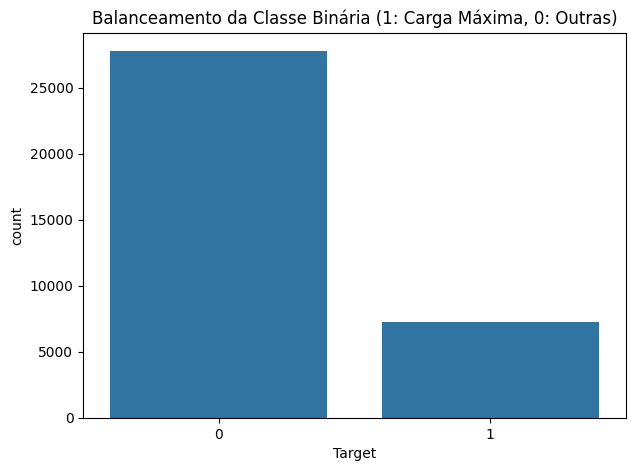

In [ ]:
# Visualizar o balanceamento
plt.figure(figsize=(7, 5))
sns.countplot(x='Target', data=df)
plt.title('Balanceamento da Classe Binária (1: Carga Máxima, 0: Outras)')
plt.show()

Discussão: Como podemos ver, as classes estão um pouco desbalanceadas. Temos mais casos de "Não Carga Máxima" (0) do que "Carga Máxima" (1). Isso é importante ter em mente ao avaliar o modelo.

## Pré-processamento

O pré-processamento das features (X) continua o mesmo. A única diferença é que agora nossa variável y será a coluna Target que acabamos de criar.

In [ ]:
# Preparando X e y para o modelo
# X continua sendo as features originais, mas sem a coluna 'Load_Type'
X = df.drop(['Load_Type', 'Target'], axis=1)
y = df['Target']

In [ ]:
# Identificar colunas numéricas e categóricas
numerical_features = X.select_dtypes(include=np.number).columns.tolist()
categorical_features = X.select_dtypes(exclude=np.number).columns.tolist()

In [ ]:
# Dividir os dados em treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)


In [ ]:
# Criar e aplicar o pipeline de pré-processing
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ])

In [ ]:
X_train_processed = preprocessor.fit_transform(X_train)
X_test_processed = preprocessor.transform(X_test)

## Treinamento e Avaliação da Regressão Logística

Agora, vamos treinar o modelo de Regressão Logística e avaliar seu desempenho com as métricas que já conhecemos.

In [ ]:
# Treinamento do modelo
# Instanciar e treinar o modelo de Regressão Logística
log_reg = LogisticRegression(random_state=26, max_iter=1000)
log_reg.fit(X_train_processed, y_train)

LogisticRegression(max_iter=5000, random_state=26)

In [ ]:
# Fazer predições no conjunto de teste
y_pred = log_reg.predict(X_test_processed)

# Avaliação
accuracy = accuracy_score(y_test, y_pred)
print(f"--- Avaliação da Regressão Logística ---")
print(f"Acurácia: {accuracy:.4f}\n")

print("Relatório de Classificação:")
print(classification_report(y_test, y_pred, target_names=['Não Carga Máxima', 'Carga Máxima']))

--- Avaliação da Regressão Logística ---
Acurácia: 0.7884

Relatório de Classificação:
                  precision    recall  f1-score   support

Não Carga Máxima       0.84      0.91      0.87      5554
    Carga Máxima       0.48      0.32      0.39      1454

        accuracy                           0.79      7008
       macro avg       0.66      0.62      0.63      7008
    weighted avg       0.76      0.79      0.77      7008



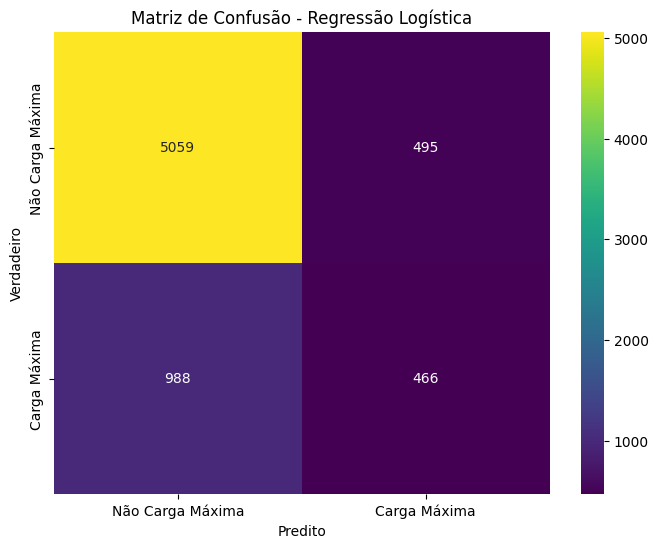

In [ ]:
# Matriz de Confusão
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='viridis',
            xticklabels=['Não Carga Máxima', 'Carga Máxima'],
            yticklabels=['Não Carga Máxima', 'Carga Máxima'])
plt.title('Matriz de Confusão - Regressão Logística')
plt.xlabel('Predito')
plt.ylabel('Verdadeiro')
plt.show()

## Bonus: Análise Avançada com Curva ROC e AUC

A acurácia pode ser enganosa em casos de classificação binária com classes desbalanceadas. Se 99% dos casos são "normais", um modelo que sempre prevê "normal" terá 99% de acurácia, mas será inútil para detectar falhas. Por isso, usamos métricas como a Curva ROC e a AUC.

- O que é a Curva ROC (Receiver Operating Characteristic)?

  - Pense nela como um gráfico que mostra o trade-off de um modelo. Ela plota a Taxa de Verdadeiros Positivos (TPR) contra a Taxa de Falsos Positivos (FPR) em todos os limiares de classificação.

  - TPR (Sensibilidade/Recall): De todos os casos que são realmente positivos (Carga Máxima), quantos o modelo acertou? (Queremos que seja alto).

  - FPR: De todos os casos que são realmente negativos (Outras Cargas), quantos o modelo errou e classificou como positivos? (Queremos que seja baixo).

  - Um modelo perfeito estaria no "canto superior esquerdo" do gráfico (100% de acertos, 0% de erros).

- O que é a AUC (Area Under the Curve)?

  - A AUC mede a área total sob a curva ROC. Ela resume a performance do modelo em um único número, variando de 0.5 a 1.0.

  - Interpretação Prática: A AUC pode ser interpretada como a probabilidade de que o modelo classifique um exemplo positivo aleatório com uma pontuação maior do que um exemplo negativo aleatório.

  - Valores de Referência:
    - AUC = 1.0: Classificador perfeito.
    - AUC > 0.8: Bom.
    - AUC entre 0.7 e 0.8: Razoável.
    - AUC = 0.5: Descartável (equivalente a um palpite aleatório).

In [ ]:
# A Regressão Logística pode nos dar a probabilidade de cada classe
y_pred_proba = log_reg.predict_proba(X_test_processed)[:, 1]

# Calcular os pontos da curva ROC
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)

# Calcular a área sob a curva (AUC)
roc_auc = auc(fpr, tpr)


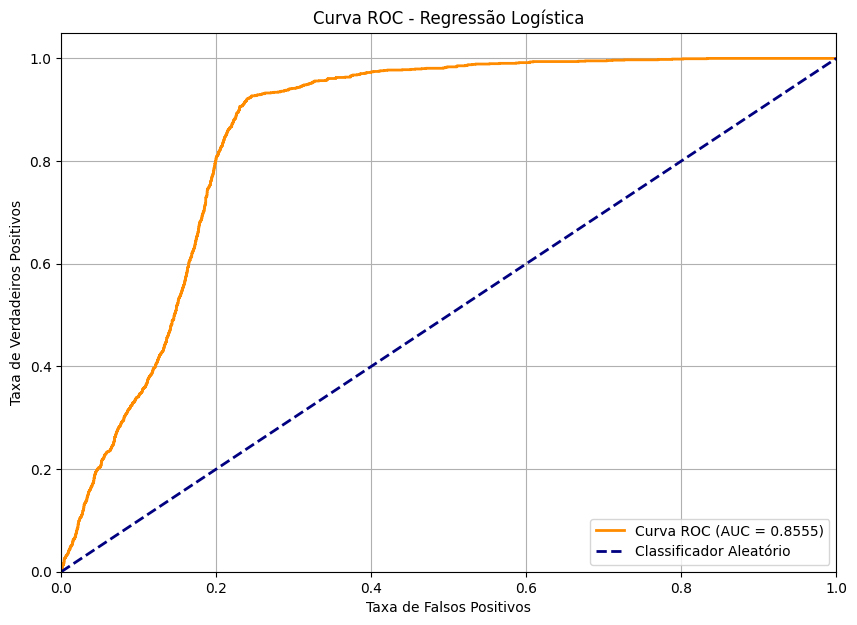


A área sob a curva (AUC) é: 0.8555


In [ ]:
# Plotar o gráfico
plt.figure(figsize=(10, 7))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'Curva ROC (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Classificador Aleatório')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Taxa de Falsos Positivos')
plt.ylabel('Taxa de Verdadeiros Positivos')
plt.title('Curva ROC - Regressão Logística')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

print(f"\nA área sob a curva (AUC) é: {roc_auc:.4f}")

Conclusão do Desafio: O valor da AUC, provavelmente muito próximo de 1.0, confirma que a Regressão Logística é um modelo extremamente eficaz para este problema de classificação binária, sendo capaz de distinguir com alta precisão quando a fábrica está ou não em carga máxima.